In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import LongType, StringType, IntegerType, StructType, StructField, DecimalType, TimestampType, DoubleType

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("app_bronze_to_silver_users") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", "1") \
    .config("spark.cores.max", "2") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.jars.packages", 
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.262,"
            "org.postgresql:postgresql:42.5.4") \
    .getOrCreate()

# Define schema
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("current_age", IntegerType(), False),
    StructField("retirement_age", IntegerType(), False),
    StructField("birth_year", IntegerType(), False),
    StructField("birth_month", IntegerType(), False),
    StructField("gender", StringType(), False),
    StructField("address", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("per_capita_income", StringType(), True),  # Read as string first
    StructField("yearly_income", StringType(), True),      # Read as string first
    StructField("total_debt", StringType(), True),         # Read as string first
    StructField("credit_score", IntegerType(), True),
    StructField("num_credit_cards", IntegerType(), True)
])

# Read CSV from MinIO
print("Reading users data from MinIO...")
df = spark.read \
    .option("header", "true") \
    .schema(schema) \
    .csv("s3a://bronze/users/users_data.csv")

# Transform data - strip $ signs and convert to decimal
print("Transforming data...")
df_transformed = df \
    .withColumn("per_capita_income", 
                regexp_replace(col("per_capita_income"), "\\$", "").cast(DecimalType(12, 2))) \
    .withColumn("yearly_income", 
                regexp_replace(col("yearly_income"), "\\$", "").cast(DecimalType(12, 2))) \
    .withColumn("total_debt", 
                regexp_replace(col("total_debt"), "\\$", "").cast(DecimalType(12, 2))) \
    .withColumn("latitude", col("latitude").cast(DecimalType(10, 6))) \
    .withColumn("longitude", col("longitude").cast(DecimalType(10, 6)))

# Print schema
print("Final Schema:")
df_transformed.printSchema()

# Show sample data
print("Sample transformed data:")
df_transformed.show(5, truncate=False)

# Write to minio bucket
df_transformed.write.mode("overwrite").parquet("s3a://silver/users/")
print("Data loaded successfully!")


Reading users data from MinIO...
Transforming data...
Final Schema:
root
 |-- id: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- latitude: decimal(10,6) (nullable = true)
 |-- longitude: decimal(10,6) (nullable = true)
 |-- per_capita_income: decimal(12,2) (nullable = true)
 |-- yearly_income: decimal(12,2) (nullable = true)
 |-- total_debt: decimal(12,2) (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- num_credit_cards: integer (nullable = true)

Sample transformed data:
+----+-----------+--------------+----------+-----------+------+------------------------+---------+-----------+-----------------+-------------+----------+------------+----------------+
|id  |current_age|retirement_age|birth_year|birth_month|gender|address           

In [ ]:
print("Stopping spark session")
spark.stop()
print("spark session stopped successfully")

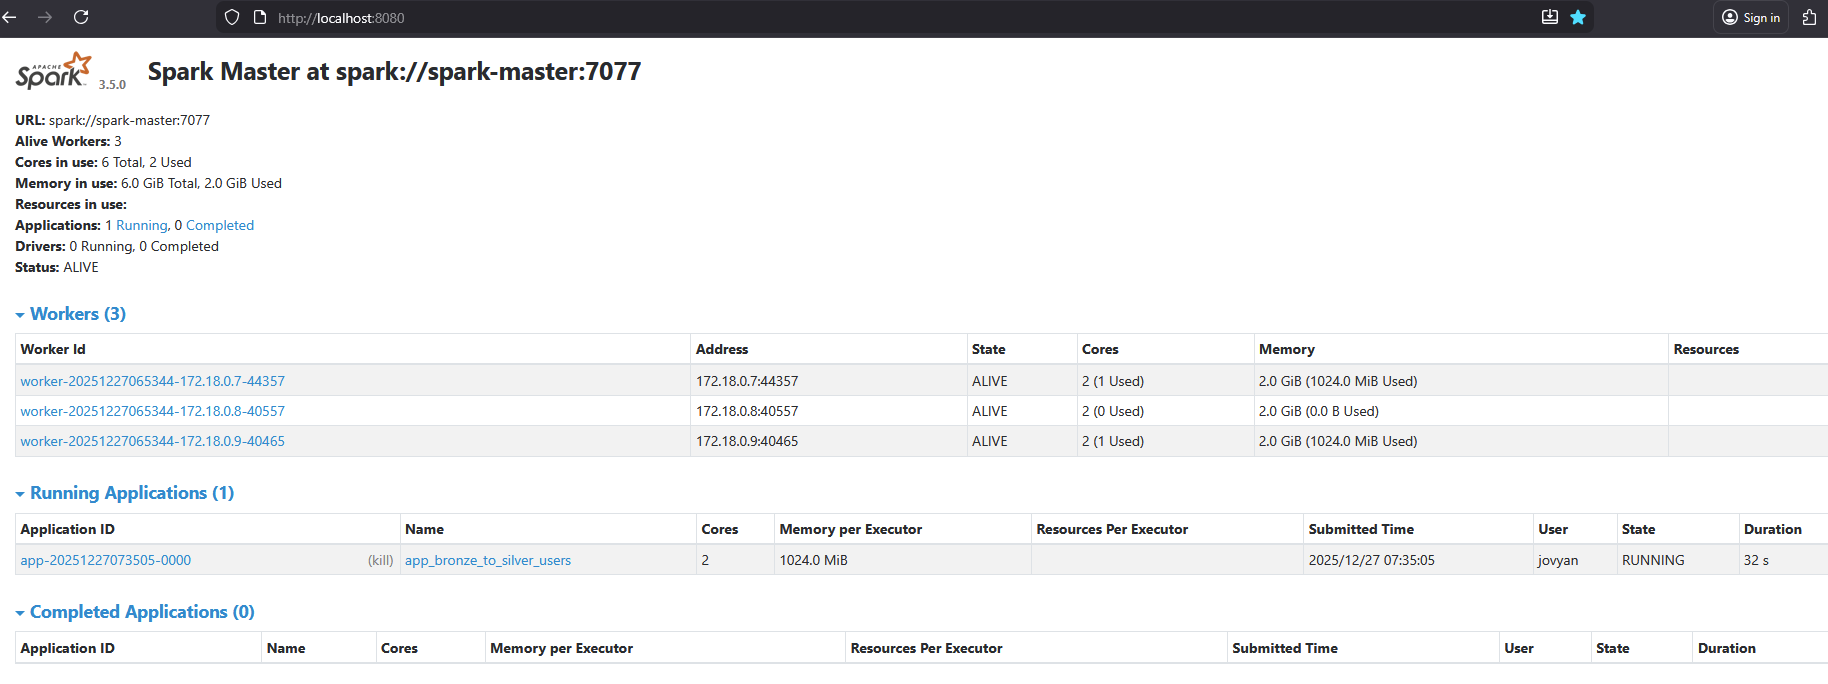

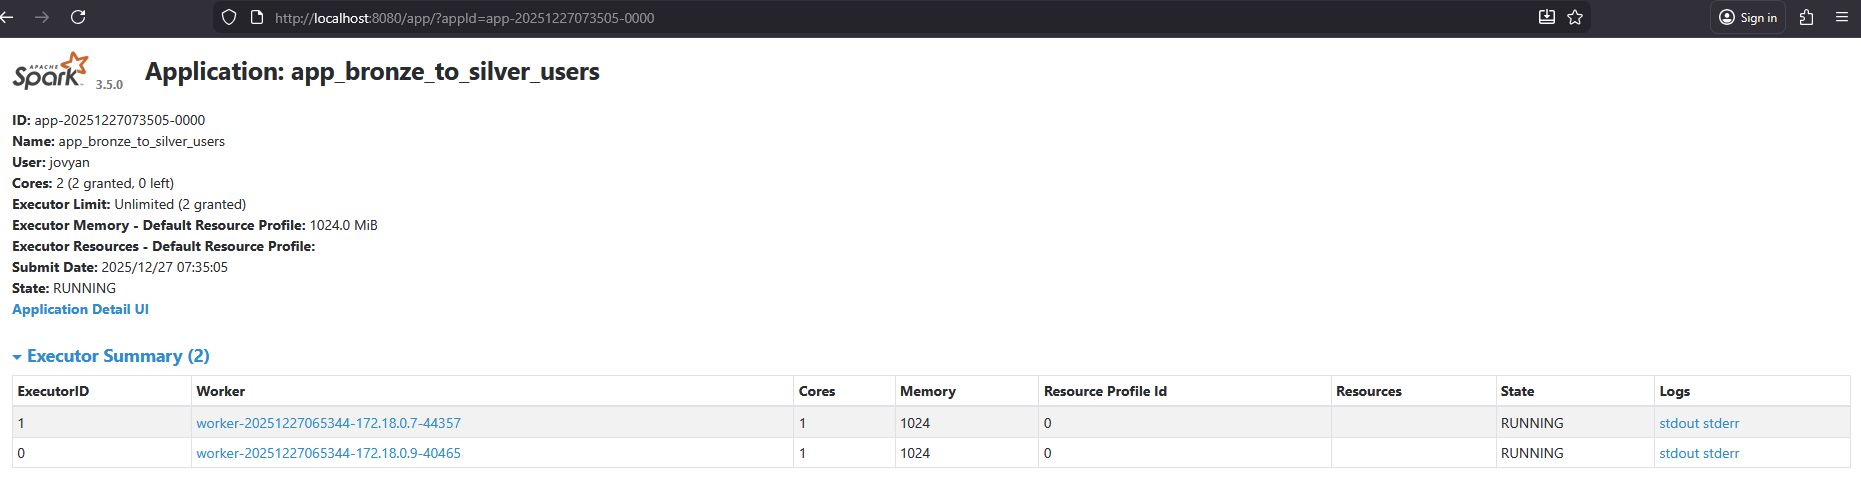